# Hamiltonian Simulation with Quantum Signal Processing and Qubitization

> **Simulating physical and chemical systems** was among the original motivations for quantum computing, as first envisioned by Richard Feynman in 1982, and remains one of its most impactful applications. Beyond its foundational goal, this quantum routine now serves as a key subroutine in many higher-level quantum algorithms, such as Quantum Linear Systems Solvers [(HHL)](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb), and applications such as [Quantum Gibbs State Sampling](https://github.com/Classiq/classiq-library/blob/main/algorithms/gibbs/quantum_thermal_state_preparation.ipynb).
>
> Time-independent Hamiltonian simulation refers to the task of approximately implementing the unitary evolution operator $e^{-iHt}$ for a Hermitian matrix $H$. When access to the Hamiltonian is provided via block-encoding, its time evolution can be realized by applying an appropriate polynomial transformation of the encoded operator, within a desired precision $\epsilon$. This polynomial transformation can be achieved via **Quantum Signal Value Transform (QSVT)** [\[1\]](#ref-grand), **Generalized QSP (GQSP)** [\[2\]](#ref-gqsp), and a direct block encoding of Chebyshev Polynomials [\[3\]](#ref-bck) (referred to as the **Qubitization** technique hereafter). These methods represent the most powerful family of known algorithms for simulating the dynamics of quantum systems whose Hamiltonians can be efficiently block-encoded, having optimal scaling in the time $t$ and error $\epsilon$.
>
> Qubitization provides a direct approach that avoids classical preprocessing but generally requires more qubits, may involve amplitude amplification, and includes controlled operations over the block-encoding unitary. QSVT, in contrast, omits such controlled operations, uses two auxiliary qubits, and requires a classical preprocessing stage to determine the signal-processing angles. The GQSP method, like Qubitization, employs controlled block-encoding calls and, like QSVT, relies on classical angle computation, but it requires only one auxiliary qubit and eliminates the need for amplification.
>
> - **Input:**
>   - A Hermitian operator (Hamiltonian) $H$, given through an oracle that implements a block-encoding of $H/\alpha$, where $\alpha \ge ||H||$ and $||\cdot||$ is the spectral norm.
>   - The evolution time $t$.
>   - The target simulation error $\epsilon$.
>
> - **Output:** A unitary $U$ that approximates the time evolution $e^{-iHt}$, such that $||U - e^{-iHt}|| < \epsilon$ ($||\cdot||$ is the spectral norm).
>
> **Complexity:** All three methods require $O\!\left(\alpha t + \frac{\log \epsilon^{-1}}{\log \!\left(e + \log(\epsilon^{-1}) / \alpha t \right)}\right)$ calls to the block-encoding unitary $U_H$. The methods differ by their classical preprocessing routines, depth, and number of auxiliary qubits.
>
> ---
>
> **Keywords:** Hamiltonian Simulation, Block Encoding, Quantum Singular Value Transformation (QSVT), Qubitization, Generalized Quantum Signal Processing, Oracle/Query complexity.


A block-encoded Hamiltonian refers to its embedding within a larger unitary matrix. 

**Definition**: A $(s, m, \epsilon)$-encoding of a $2^n\times 2^n$ matrix $H$ refers to completing it into a $2^{n+m}\times 2^{n+m}$ unitary matrix $U_{(s,m,\epsilon)-H}$:
$$
U_{(s,m,\epsilon)-H} = \begin{pmatrix}
H/s & * \\
* & *
\end{pmatrix},
$$
with some functional error $\left|\left|\left(U_{(s,m,\epsilon)-H}\right)_{0:2^n-1,0:2^n-1}-H/s \right|\right|\leq \epsilon$. The idea is that typically we would like to apply operations on non-unitary matrices. Since quantum circuits can only implement unitary operations, block-encoding embeds a generally non-unitary matrix into a larger unitary one. The scaling factor $s$ ensures that the overall operator remains unitary. For the most basic use of block-encoding, see the first item in the technical notes at the end of this notebook.

In all three methods presented in this notebook, we assume to have an exact $(s, m, 0)$-encoding of some Hamiltonian as an input, where the output of each method implements an approximated encoding of its Hamiltonian evolution
$$
U_{(s,m,\epsilon)-H} \rightarrow U_{(\tilde{s},\tilde{m},\epsilon)-\exp{(-iHt)}} = \begin{pmatrix}
\exp{(-iHt)}/\tilde{s} & * \\
* & *
\end{pmatrix}.
$$
This will be acheived by implementing a block-encoding for the polynomial approximation of a function of the Hamiltonian, $P(H)\approx \frac{1}{\tilde{s}}e^{-iHt}$, with $\tilde{s}$ being some scaling factor. Note that to get the approximated unitary of $e^{-iHt}$, we have to apply amplitude amplification for $\tilde{s}\rightarrow 1$, see for example the [Oblivious Amplitude Amplification noteook](https://github.com/Classiq/classiq-library/blob/main/algorithms/oblivious_amplitude_amplification/oblivious_amplitude_amplification.ipynb), or apply some post-selection. The amplification step is beyond the scope of the current example, and we simply employ projected statevector simulation.


**<div class="alert alert-success"> This notebook demonstrates how to implement Hamiltonian simulation with all three methods: GQSP, Qubitization, and QSVT. Each method is explained and defined independently. We start with some preliminary steps, that are common to all three methods. In addition, in the last section we present a summary that compares between the properties of the three methods.</div>**

## Preliminaries

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy

from classiq import *

### Setting a specific Hamiltonian to Evolve

We start with setting some specific hyperparameters for our problem. Those can be easily modified to treat different usecases.
We set a specific block-encoded Hamiltonian to evolve, taking a simple example of a Hamiltonian as a sum of Pauli strings, and use the `lcu_paulis` function to block-encode it. The idea of the Linear Combination of Unitaries (LCU) technique, which also appears in the QSVT and Qubitization methods, is the following:

**Definition**: LCU refers to $(\bar{\alpha}, m, 0)$-block-encoding of a matrix given as a sum of unitaries:
$$
U_{(\bar{\alpha},m,0)-A} =\begin{pmatrix}
A/\bar{\alpha} & * \\
* & *
\end{pmatrix}, \text{   for     } A = \sum^{L-1}_{i=0} \alpha_i U_i, \,\,\,\,\, \alpha_i\geq 0
$$
with $\bar{\alpha}\equiv\sum^{L-1}_{i=0}\alpha_i$ and $m= \lceil\log_2(L) \rceil$. The LCU is implemented with the so-called "prepare" and "select" operations. The former prepares a quantum state that corresponds to the probabilities $\alpha_i /\sum\alpha_i$, and the latter acts as a quantum switch operation. See second item at the Technical Details at the end of this notebook, and the [LCU tutorial](https://github.com/Classiq/classiq-library/blob/main/tutorials/basic_tutorials/quantum_primitives/linear_combination_of_unitaries/linear_combination_of_unitaries.ipynb) for more details.

We now set the input parameters for the specific problem, which include:
1. The time evolution $t$ and the error $\epsilon$.
2. The Hamiltonian $H$ and its block-encoding quantum function.

In [2]:
EVOLUTION_TIME = 22
EPS = 0.1

HAMILTONIAN = (
    0.4 * Pauli.I(0)
    + 0.1 * Pauli.Z(1)
    + 0.05 * Pauli.X(0) * Pauli.X(1)
    + 0.2 * Pauli.Z(0) * Pauli.Z(1)
)
print(f"The Hamiltonian to evolve: {HAMILTONIAN}")

The Hamiltonian to evolve: 0.4*Pauli.I(0) + 0.1*Pauli.Z(1) + 0.05*Pauli.X(0)*Pauli.X(1) + 0.2*Pauli.Z(0)*Pauli.Z(1)




$$
H = \sum^{L-1}_{i=0} \alpha_i U_i,
$$
where $U_i$ are Pauli strings.

The LCU of the Hamiltonian corresponds to the unitary:
$$
U_{H} = \begin{pmatrix}
\frac{1}{s}\sum^{L-1}_{i=0} \alpha_i U_i & * \\
* & *
\end{pmatrix},  \text{   with  } s = \sum\alpha_i.
$$

Let us derive some additional parameters for the implementation, such as the block-encoding size and the scaling factor $s$. 

In [3]:
data_size = HAMILTONIAN.num_qubits
block_size = (
    (len(HAMILTONIAN.terms) - 1).bit_length() if len(HAMILTONIAN.terms) != 1 else 1
)
be_scaling = np.sum(np.abs([term.coefficient for term in HAMILTONIAN.terms]))

Next, we define the block-encoding quantum function, and a Quantum Struct for its variable

In [4]:
class BlockEncodedState(QStruct):
    data: QNum[data_size]
    block: QNum[block_size]


@qfunc
def be_hamiltonian(state: BlockEncodedState):
    lcu_pauli(HAMILTONIAN * (1 / be_scaling), state.data, state.block)

Finally, we set the initial state to evolve and calculate classically the expected evolved state for verifying the quantum methods.

In [5]:
state_to_evolve = np.random.rand(2**data_size)
state_to_evolve = (state_to_evolve / np.linalg.norm(state_to_evolve)).tolist()
matrix = pauli_operator_to_matrix(HAMILTONIAN)
expected_state = scipy.linalg.expm(-1j * matrix * EVOLUTION_TIME) @ state_to_evolve

### Setting Up a State Vector Simulator for Execution

Working with block-encoding typically requires post-selection of the block variables being at state 0. The success of this process can be amplified via a Quantum Amplitude Amplification routine. I`n this notebook, instead, we simply work with a statevector simulator. We define a function that gets execution results and returns a projected state vector.

In [6]:
## fix the execution preferences for this notebook
execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)

In [7]:
def get_projected_state_vector(res) -> np.ndarray:
    """
    This function returns a reduced statevector from execution results.
    Expects a 'data' variable, and a 'block' variable to be filtered out when not in the |0> state.
    """
    state_size = 2 ** len(res.output_qubits_map["data"])
    proj_statevector = np.zeros(state_size).astype(complex)

    df = res.dataframe
    # Filter only the successful states.
    filtered_st = df[(df.block == 0) & (np.abs(df.amplitude) > 1e-12)]
    proj_statevector[filtered_st.data] = filtered_st.amplitude
    return proj_statevector

#### Defining a Utility Function for State Overlap

Below we define a *classical* post-process function that will be used to verify the quantum results, by comparing them to the expected classical result.

In [8]:
def compare_quantum_classical_states(
    expected_state: np.ndarray, resulted_state: np.ndarray, post_selection_factor: float
):
    """
    Aligns global phase, renormalizes, and computes overlap between the expected classical state
    and the one resulting from the quantum program. Since we work with a projected statevector, we need to insert the post-selection by hand.

    Parameters
    ----------
    expected_state : array_like of complex, the classical (reference) statevector.
    resulted_state : array_like of complex, the simulated statevector, projected onto the block=0 space.
    post_selection_factor : float, the post-selection success probability of the block=0, to be applied uniformly to `resulted_state`.

    Returns
    -------
    renormalized_state : the `resulted_state` after global-phase alignment and multiplication by `post_selection_factor`.
    overlap : The absolute value of the normalized inner product between `renormalized_state` and `expected_state`.
    """

    relative_phase = np.angle(expected_state[0] / resulted_state[0])
    resulted_state = resulted_state * np.exp(
        1j * relative_phase
    )  # rotate according to a global phase

    renormalized_state = post_selection_factor * resulted_state
    overlap = (
        np.vdot(renormalized_state, expected_state)
        / np.linalg.norm(renormalized_state)
        / np.linalg.norm(expected_state)
    )

    return renormalized_state, abs(overlap)

### The Jacobi–Anger Expansion

The core of all the three methods is the polynomial approximation of the evolution, this transformation relies on the Jacobi-Anger expansion [<a href="#ref-jawiki">4</a>].

The most general form of the Jacobi–Anger expansion gives:
<div style="margin-bottom:0">
\begin{align}
e^{it\cos(x)} &= \sum_{k=-\infty}^{\infty} i^k J_{k}(t) e^{ikx}, && (1)\\ 
e^{it\sin(x)} &= \sum_{k=-\infty}^{\infty} J_{k}(t) e^{ikx}, && (2)
\end{align}
</div>
from which, we can also get the expansion for the sine and cosine functions using Chebyshev polynomials:
<div style="margin-bottom:0">
\begin{align}
\cos(xt) &= J_0(t) + 2\sum_{k=1}^{d/2} (-1)^k J_{2k}(t)\, T_{2k}(x),&& (3)\\
\sin(xt) &= 2\sum_{k=0}^{d/2} (-1)^k J_{2k+1}(t)\, T_{2k+1}(x), && (4)
\end{align}
</div>
where $J_i(x)$ and $T_i(x)$ are the Bessel function and Chebyshev polynomial of order $i$, respectively. The infinite series can be trimmed at some degree $d$, giving an approximation for the functions, whose relation to the error bound $\epsilon$ is
<div style="margin-bottom:0">
$$
d = O\!\left(t + \frac{\log(1/\epsilon)}{\log\!\Big(e+\frac{\log(1/\epsilon)}{t}\Big)}\right).\quad (5)
$$
</div>
We start with defining a function that gets $\epsilon$ and the evolution time $t$, and returns the Chebyshev coefficients of the sine and cosine functions, using the `scipy` package.

In [9]:
from scipy.special import eval_chebyt, jv


def get_jacobi_anger_degree(epsilon, t):
    # Equation (5) follows from the asymptotic estimate, taking a factor of 2 as a safety margin
    return 2 * int(
        np.ceil(
            t
            + np.log(epsilon ** (-1)) / np.log(np.exp(1) + np.log(epsilon ** (-1)) / t)
        )
    )


def get_exp_cheb_coeffs(epsilon, t):
    poly_degree = get_jacobi_anger_degree(epsilon, t)
    cos_coeffs = [jv(0, t)] + [
        2 * jv(2 * k, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    sin_coeffs = [
        -2 * jv(2 * k - 1, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    exp_coeffs = np.zeros((poly_degree // 2) * 2 + 1).astype(complex)
    exp_coeffs[::2] = cos_coeffs
    exp_coeffs[1::2] = -1j * np.array(sin_coeffs)
    return exp_coeffs

We can examine the approximation for a specific example:

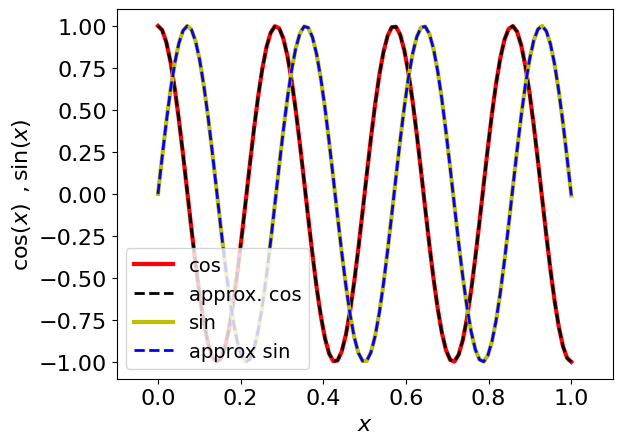

In [10]:
exp_coeffs = get_exp_cheb_coeffs(EPS, EVOLUTION_TIME)

xs = np.linspace(0, 1, 100)
approx_exp = sum([exp_coeffs[k] * eval_chebyt(k, xs) for k in range(len(exp_coeffs))])

plt.plot(xs, np.cos(EVOLUTION_TIME * xs), "-r", linewidth=3, label="cos")
plt.plot(xs, np.real(approx_exp), "--k", linewidth=2, label="approx. cos")
plt.plot(xs, np.sin(EVOLUTION_TIME * xs), "-y", linewidth=3, label="sin")
plt.plot(xs, -np.imag(approx_exp), "--b", linewidth=2, label="approx sin")
plt.ylabel(r"$\cos(x)\,\,\, , \sin(x)$", fontsize=16)
plt.xlabel(r"$x$", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc="lower left", fontsize=14)
plt.xlim(-0.1, 1.1);

### Defining a Walk Operator

This part is relevant to the Qubitization and GQSP methods. **These two methods assumes that the block-encoding unitary $U_H$ is also Hermitian, a generalization is given at the third item in the Technical Details section**.

Given the block-encoding $U_{(s,m,0)-H}$, we can define the following *unitary* operator (usually called the Szegedy quantum walk operator [<a href="#ref-szegedy">5</a>]):
$$
W\equiv \Pi_{|0\rangle_m} U_{(s,m,0)-H},
$$  
where $\Pi_{|0\rangle_m}$ is a reflection operator about the block state 0. 

We start with defining a walk operator for our specific example. For the reflection, we use the `reflect_about_zero` quantum function from the Classiq open library.

In [11]:
from classiq.qmod.symbolic import pi


@qfunc
def walk_operator(
    be_qfunc: QCallable[BlockEncodedState], state: BlockEncodedState
) -> None:
    be_qfunc(state)
    reflect_about_zero(state.block)
    phase(pi)

This unitary function has the following important properties (see Section 7 in Ref. [<a href="#ref-lin">6</a>] ) :
1. Its powers correspond to a $(1,m,0)$-encoding of the Chebyshev polynomials:
$$
W^k = \begin{pmatrix}
T_k(H/s) & * \\
* & *
\end{pmatrix}=U_{(1,m,0)-T_k(H/s)}, \quad (6)
$$
with $T_k$ being the k-th Chebyshev polynomial. 
2. Its specturm has a nice relation to the spectrum of the block-encoded Hamiltonian:
  $$
  \text{eigenvalues: } e^{\pm i \arccos(\lambda/s)}, \text{ with eigenvectors:  } |\varphi^{\pm}_{\lambda}\rangle \equiv \frac{1}{\sqrt{2}}\left(|v_{\lambda}\rangle |0\rangle_m \pm i|\perp_{\lambda}\rangle\right), \quad (7)
  $$
  where $|v_\lambda\rangle$ is an eigenstate of the Hamiltonian $H$ with an eigenvalue $\lambda$.

### Verifying the Block-Encoding

As a final sanity check of the preliminary definitions, and before moving to the more complex Hamiltonian simulation implementation, let us quickly verify the Hamiltonian block-encoding. For this, we define a model that applies $U_H$ on the state we would like to evolve, and verify that the resulting state, after post-selection, gives $(H/\bar{\alpha})\vec{b}$.

In [12]:
@qfunc
def main(data: Output[QNum[data_size]], block: Output[QNum[block_size]]):
    state = BlockEncodedState()
    allocate(state)

    inplace_prepare_amplitudes(state_to_evolve, 0.0, state.data)
    be_hamiltonian(state)
    bind(state, [data, block])


qprog_be = synthesize(main)
show(qprog_be)

Quantum program link: https://platform.classiq.io/circuit/35YoJUCYNGun2vibzsiom87OQ79


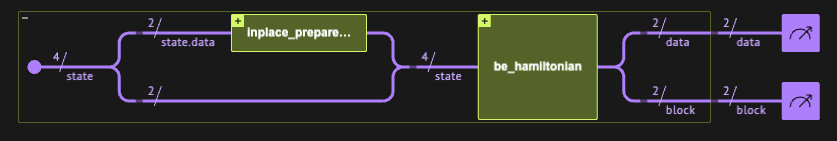

In [13]:
with ExecutionSession(qprog_be, execution_preferences=execution_preferences) as es:
    res_be = es.sample()

We use the predefined function for the post-selection, and the utility function for examining the result with respect to the expected one:

In [ ]:
state_result_be = get_projected_state_vector(res_be)
expected_state_be = matrix @ state_to_evolve

In [15]:
renormalized_be, overlap_be = compare_quantum_classical_states(
    expected_state_be, state_result_be, be_scaling
)
print("expected state:", expected_state_be)
print("resulting state after rescaling:", renormalized_be)
assert np.linalg.norm(renormalized_be - expected_state_be) < EPS
print("=" * 40)
print("overlap between expected and resulting state:", overlap_be)

expected state: [0.28681937+0.j 0.16684604+0.j 0.05667881+0.j 0.37803689+0.j]
resulting state after rescaling: [0.28681937+4.23639617e-17j 0.16684604+1.20086734e-16j
 0.05667881+8.01301034e-17j 0.37803689-2.44238701e-16j]
overlap between expected and resulting state: 1.0


***
***
## Hamiltonian Simulation with GQSP

Comment: The current implementation assumes that the block encoding **unitary** is also a Hermitian matrix (see third item at the Technical Notes below).

The GQSP method applies a polynomial transformation on a *unitary*, see <a href="https://github.com/Classiq/classiq-library/blob/main/algorithms/gqsp/gqsp.ipynb"> GQSP notebook</a>. The idea is to work with the walk operator, applying for it the polynomial transformation
$$
P(z) = \sum_{k=-d}^{d} i^k J_k(-st) z^{k},
$$
which approximates $e^{-ist\cos(\theta)}$ according to the Jacobi-Anger expansion, see Eq. (1) above.

To see why it works, we use the second property of the walk operator in Eq. (7), to write
$$
W = \sum_{\lambda} e^{i \arccos(\lambda/s)} |\varphi^{+}_{\lambda}\rangle \langle \varphi^{+}_{\lambda}| + e^{-i \arccos(\lambda/s)} |\varphi^{-}_{\lambda}\rangle \langle \varphi^{-}_{\lambda}|,
$$
where $\lambda$ are the eigenvalues of the Hamiltonian $H$. The polynomial transformation works on each eigenvalue and gives
$$P(W) = \sum_{\lambda} P(e^{i \arccos(\lambda/s)}) |\varphi^{+}_{\lambda}\rangle \langle \varphi^{+}_{\lambda}| + P(e^{-i \arccos(\lambda/s)})|\varphi^{-}_{\lambda}\rangle \langle \varphi^{-}_{\lambda}| = 
\sum_{\lambda} e^{-i \lambda t}\left( |\varphi^{+}_{\lambda}\rangle \langle \varphi^{+}_{\lambda}| + |\varphi^{-}_{\lambda}\rangle \langle \varphi^{-}_{\lambda}|\right).$$
When this unitary is applied on some state $|\psi\rangle|0\rangle_m$ we get, approximately,  
$$
P(W)|\psi\rangle|0\rangle_m \approx e^{-iHt}|\psi\rangle|0\rangle_m.
$$

Applying a GQSP requires calculating a series of GQSP angles, which rotate an extra qubit. For a stable convergence of this classical preprocess, we need to take some scaling factor $\beta_{\rm  gqsp} P(z)$ with $\beta_{\rm gqsp}<1$. Below we take $\beta_{\rm gqsp}=0.99$. 
We use the `gqsp` function from the open-library and the classical `gqsp_phases`. The resulting unitary of the GQSP routine is a $(\beta_{\rm gqsp}^{-1}, m+1,\epsilon)$-encoding for the Hamiltonian simulation:
$$
U_{(\beta_{\rm gqsp}^{-1}, m+1,\epsilon)-\exp{(-iHt)}} = \begin{pmatrix}
\beta_{\rm  gqsp}\exp{(-iHt)} & * \\
* & *
\end{pmatrix}.
$$
where $m$ is the block size of the Hamiltonian block-encoding.

### Implementation

We find the GQSP angles, and define a Quantum Struct for the Hamiltonian evolution function.

In [16]:
from classiq.applications.qsp import gqsp_phases

GQSP_SCALE = 0.99
t0 = time.perf_counter()
gqsp_degree = get_jacobi_anger_degree(EPS, EVOLUTION_TIME * be_scaling)
jacobi_anger_poly_expcos = [
    GQSP_SCALE * jv(k, -EVOLUTION_TIME * be_scaling) * (1j**k)
    for k in range(-gqsp_degree, gqsp_degree + 1)
]
jacobi_anger_phases_expcos = gqsp_phases(jacobi_anger_poly_expcos)
classical_preprocess_time_gqsp = time.perf_counter() - t0

We define a Quantum Struct for the GQSP block-encoding:

In [17]:
class GQSPBlock(QStruct):
    block_ham: QNum[block_size]
    block_gqsp: QBit


class GQSPState(QStruct):
    data: QNum[data_size]
    block: GQSPBlock

Next, we construct a quantum function that gets the GQSP parameters, the `gqsp_phases` and `negative_power` defining the polynomial, and the block-encoding function as a parameter. A negative power is needed, since the approximation of $e^{-it\cos(x)}$ in Eq. (1) is a Laurent polynomial that includes negative powers as well.

In [18]:
@qfunc
def gqsp_hamiltonian_evolution(
    gqsp_expcos_phases: CArray[CArray[CReal], 3],
    negative_power: int,
    be_qfunc: QCallable[BlockEncodedState],
    state: GQSPState,
):
    gqsp(
        u=lambda: walk_operator(be_qfunc, [state.data, state.block.block_ham]),
        aux=state.block.block_gqsp,
        phases=gqsp_expcos_phases,
        negative_power=negative_power,
    )

The code in the rest of this section builds a model that applies the `gqsp_hamiltonian_evolution` function on the randomly prepared vector $(\vec{\psi},\vec{0})$, synthesizes it, executes the resulting quantum program, and verifies the results. 

In [19]:
@qfunc
def main(data: Output[QNum[data_size]], block: Output[QNum[block_size + 1]]):
    state = GQSPState()
    allocate(state)

    inplace_prepare_amplitudes(state_to_evolve, 0.0, state.data)
    gqsp_hamiltonian_evolution(
        jacobi_anger_phases_expcos, gqsp_degree, be_hamiltonian, state
    )

    bind(state, [data, block])


write_qmod(
    main, "hamiltonian_simulation_gqsp", decimal_precision=12, symbolic_only=False
)

In [20]:
# Synthesize
qprog_gqsp = synthesize(main)
show(qprog_gqsp)

Quantum program link: https://platform.classiq.io/circuit/35YoY7rjOm6y7kt2IuerW6mic75


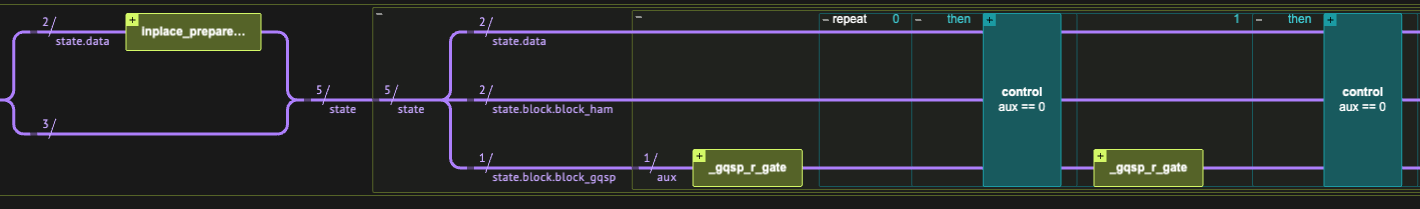

In [21]:
# Execute and construct the projected statevector
with ExecutionSession(qprog_gqsp, execution_preferences) as es:
    result_gqsp = es.sample()

state_result_gqsp = get_projected_state_vector(result_gqsp)
exp_scaling_factor_gqsp = 1 / GQSP_SCALE

For the verification, we call the pre-defined function for calculating the overlap:

In [22]:
renormalized_state_gqsp, overlap_gqsp = compare_quantum_classical_states(
    expected_state, state_result_gqsp, exp_scaling_factor_gqsp
)
print("expected state:", expected_state)
print("resulting state after rescaling:", renormalized_state_gqsp)
assert np.linalg.norm(renormalized_state_gqsp - expected_state) < EPS
print("=" * 40)
print("overlap between expected and resulting state:", overlap_gqsp)

expected state: [-0.46396295-0.16168895j  0.47484851-0.25755303j  0.04128442-0.24362525j
 -0.27002281+0.57689723j]
resulting state after rescaling: [-0.46396295-0.16168895j  0.47484851-0.25755302j  0.04128442-0.24362525j
 -0.27002281+0.57689723j]
overlap between expected and resulting state: 1.0


***
***

## Hamiltonian Simulation with QSVT

The QSVT is a general technique for applying block-encoding of matrix polynomials via quantum signal processing. Refer to Ref. [<a href="#ref-grand">1</a>] and the [QSVT notebook](https://github.com/Classiq/classiq-library/blob/main/algorithms/qsvt/qsvt_matrix_inversion/qsvt_matrix_inversion.ipynb) for more information about this generic and important subject. The QSVT supports polynomials with a well defined parity. Thus, we can apply two QSVT blocks- one for approximating the $\cos(xt)$ function and one for the $\sin(xt)$ function- and then, for the finale, we construct an LCU to get the block-encoding of the sum $e^{-ixt} = \cos(xt)-i\sin(xt)$. For a realization of such a model on real hardware, see Ref. [<a href="#ref-kikuchi">7</a>].

The QSVT routine requires pre-calculation of rotation angles on an extra qubit. For the stability of this classical preprocess, it is essential to work with $\beta_{\cos} \cos(xt)$ and $\beta_{\sin} \sin(xt)$, where $\beta_{\cos} , \beta_{\sin} <1 $. Below we take $\beta_{\cos}= \beta_{\sin}=0.99$.

To apply the LCU of the even and odd QSVT routine, we call the `qsvt_lcu` function from the open-library, that performs a non-trivial, optimized `select` operation for the two QSVT calls, as described in the figure below.

Overall, the LCU of the two unitaries: $U_{(\beta_{\cos}^{-1},m+1,\epsilon)-\cos(Ht)} - iU_{(\beta_{\sin}^{-1},m+1,\epsilon)-\sin(Ht)}$, gives a $(2\beta_{\cos}^{-1}, m+2,\epsilon)$-encoding for the Hamiltonian simulation:
$$
U_{((2\beta_{\cos}^{-1}, m+2,\epsilon))-\exp{(iHt)}} = \begin{pmatrix}
\frac{\beta_{\cos}}{2}\exp{(iHt)} & * \\
* & *
\end{pmatrix},
$$
where $m$ is the block size of the Hamiltonian block-encoding.

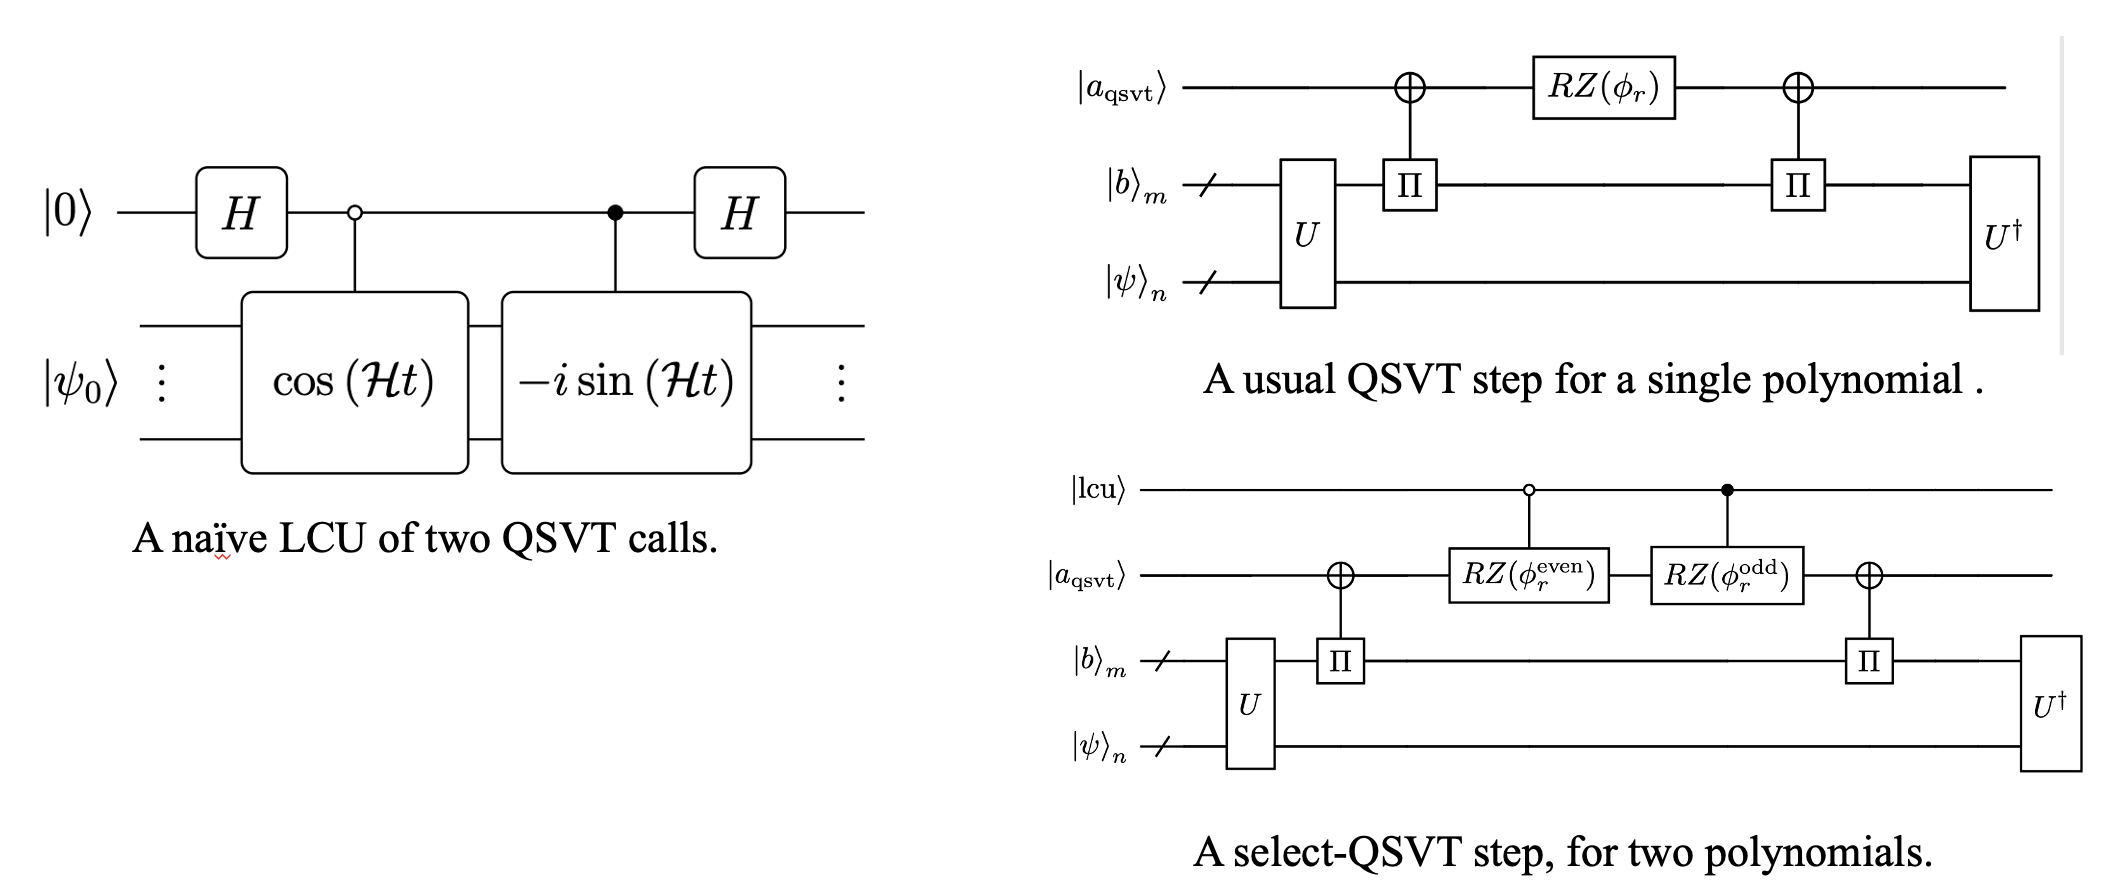
<center> On the left is the naive LCU design for the select of two QSVT calls (taken from Ref. [<a href="#ref-grand">1</a>] ), where each call is applied using a repetition over the usual QSVT step on the upper right panel, where each polynomial is acheived by its own series of angles $\phi_r$. However, one can design an optimized select operation, by selecting the rotations within the QSVT steps themselves, as shown in the lower right panel.</center>

### Implementation

We start by calculating the rotation angles for the sine and cosine polynomial approximations, adding a factor of $0.99$.

In [23]:
from classiq.applications.qsp import qsvt_phases

t0 = time.perf_counter()
exp_coeffs = get_exp_cheb_coeffs(EPS, EVOLUTION_TIME * be_scaling)

COS_SCALE = SIN_SCALE = 0.99
poly_even = np.real(COS_SCALE * exp_coeffs)
phases_cos = qsvt_phases(poly_even)

poly_odd = -np.imag(SIN_SCALE * exp_coeffs)
phases_sin = qsvt_phases(poly_odd)

classical_preprocess_time_qsvt = time.perf_counter() - t0

assert np.abs(len(phases_sin) - len(phases_cos)) <= 1

Next, we use Classiq's `prepare_select` function, which allows a flexible implementation of the select operation in LCU. In our case we take this operation to be the `qsvt_lcu` function. The coefficients $(1/2,-i/2)$ are chosen to get the desired $\exp(-ix)$ polynomial.

In [24]:
class QSVTBlock(QStruct):
    block_ham: QNum[block_size]
    block_qsvt: QBit
    block_lcu: QBit


class QSVTState(QStruct):
    data: QNum[data_size]
    block: QSVTBlock


@qfunc
def qsvt_hamiltonian_evolution(
    phases_cos: list[float],
    phases_sin: list[float],
    be_qfunc: QCallable[BlockEncodedState],
    state: QSVTState,
):
    def projector_cnot(q: QBit):
        q ^= state.block.block_ham > 0

    prepare_select(
        coefficients=[1 / 2, -1j / 2],
        select=lambda block_lcu: qsvt_lcu(
            phases_cos,
            phases_sin,
            projector_cnot,
            projector_cnot,
            lambda: be_qfunc([state.data, state.block.block_ham]),
            state.block.block_qsvt,
            block_lcu,
        ),
        block=state.block.block_lcu,
    )

The code in the rest of this section builds a model that applies the `qsvt_hamiltonian_evolution` function on the randomly prepared vector $(\vec{\psi},\vec{0})$, synthesizes it, executes the resulting quantum program, and verifies the results. 

In [25]:
@qfunc
def main(data: Output[QNum[data_size]], block: Output[QNum[block_size + 2]]):

    state = QSVTState()
    allocate(state)
    inplace_prepare_amplitudes(state_to_evolve, 0.0, state.data)
    qsvt_hamiltonian_evolution(phases_cos, phases_sin, be_hamiltonian, state)
    bind(state, [data, block])


write_qmod(
    main, "hamiltonian_simulation_qsvt", decimal_precision=12, symbolic_only=False
)

In [26]:
qprog_qsvt = synthesize(main)
show(qprog_qsvt)

Quantum program link: https://platform.classiq.io/circuit/35YodxTb6oJlAW9r1JtQtwx3il2


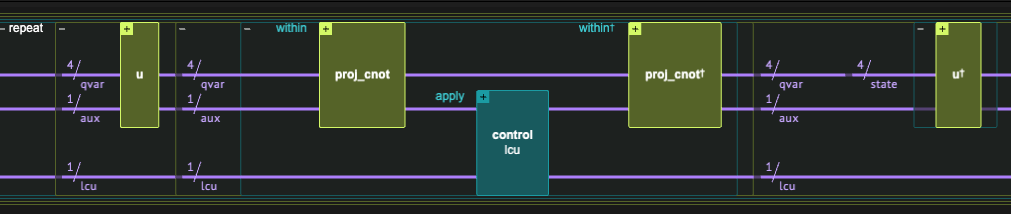

In [27]:
with ExecutionSession(qprog_qsvt, execution_preferences) as es:
    results_qsvt = es.sample()

state_result_qsvt = get_projected_state_vector(results_qsvt)
exp_scaling_factor_qsvt = 2 * (1 / COS_SCALE)

For the verification, we call the pre-defined function for calculating the overlap:

In [28]:
renormalized_state_qsvt, overlap_qsvt = compare_quantum_classical_states(
    expected_state, state_result_qsvt, exp_scaling_factor_qsvt
)
print("expected state:", expected_state)
print("resulting state after rescaling:", renormalized_state_qsvt)
assert np.linalg.norm(renormalized_state_qsvt - expected_state) < EPS
print("=" * 40)
print("overlap between expected and resulting state:", overlap_qsvt)

expected state: [-0.46396295-0.16168895j  0.47484851-0.25755303j  0.04128442-0.24362525j
 -0.27002281+0.57689723j]
resulting state after rescaling: [-0.46396295-0.16168895j  0.47484851-0.25755303j  0.04128442-0.24362525j
 -0.27002281+0.57689723j]
overlap between expected and resulting state: 1.0000000000000002


***
***
## Hamiltonian Simulation with Qubitization

Comment: The current implementation assumes that the block encoding **unitary** is also a Hermitian matrix (see third item in the Technical Notes below).

From the first property of the walk operator, Eq. (6) , we can simply combine the Jacobi–Anger expansion with the LCU technique to get the block-encoding for the Hamiltonian simulation [<a href="#ref-childs">8</a>]. Namely, we have an $\epsilon$-approximation of $\exp(-iHt)\approx \sum^d_{i=0} \beta_{i} T_{i}(x)$, for which you can perform the following encoding:
$$
U_{(\bar{\beta},\tilde{m},\epsilon)-\exp{(-iHt)}} =
\begin{pmatrix}
\exp{(-iHt)}/\bar{\beta} & * \\
* & *
\end{pmatrix}=
\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} U_{(1,m,0)-T_k(H)} & * \\
* & *
\end{pmatrix}=
\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} T_{k}(Ht) & * \\
* & *
\end{pmatrix}
=\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} W^k & * \\
* & *
\end{pmatrix},
$$
where $\tilde{m}=m+\lceil \log_2(d+1) \rceil$, where $m$ is the block size of the Hamiltonian block-encoding (recalling that $W^k$ are block-encodings themselves, with block size $m$).


### Implementation

First, we use the predefined function to calculate the coefficients $\beta_i$ for approximating the sine and cosine functions. Recall that we must rescale the time by the block-encoding scaling factor for $H$.

In [29]:
t0 = time.perf_counter()
exp_coeffs = get_exp_cheb_coeffs(EPS, EVOLUTION_TIME * be_scaling)
classical_preprocess_time_chec_lcu = time.perf_counter() - t0

We need to build an LCU of the unitaries $\{ W^k\}$, with the following parameters:

In [30]:
exp_block_size = (len(exp_coeffs) - 1).bit_length() if len(exp_coeffs) != 1 else 1
print(f"The block size of the block-encoded Hamiltonian evolution is: {exp_block_size}")
exp_be_scaling = np.sum(np.abs(exp_coeffs))
print(
    f"The scaling factor for the block-encoded Hamiltonian evolution is: {exp_be_scaling}"
)

The block size of the block-encoded Hamiltonian evolution is: 6
The scaling factor for the block-encoded Hamiltonian evolution is: 5.626479051326803


In principle, we could use the `lcu` function from the open-library, however, since the unitaries are just a series of powers of the same unitary, we can devise a better design to the `select` operator, as depicted in the figure below (this is similar to the construction of the QPE algorithm). Note that in this construction, the `select` operator runs over all powers $0,1,\dots, 2^{l}-1$, with $l=2^{\lceil \log_2(d+1) \rceil}.$

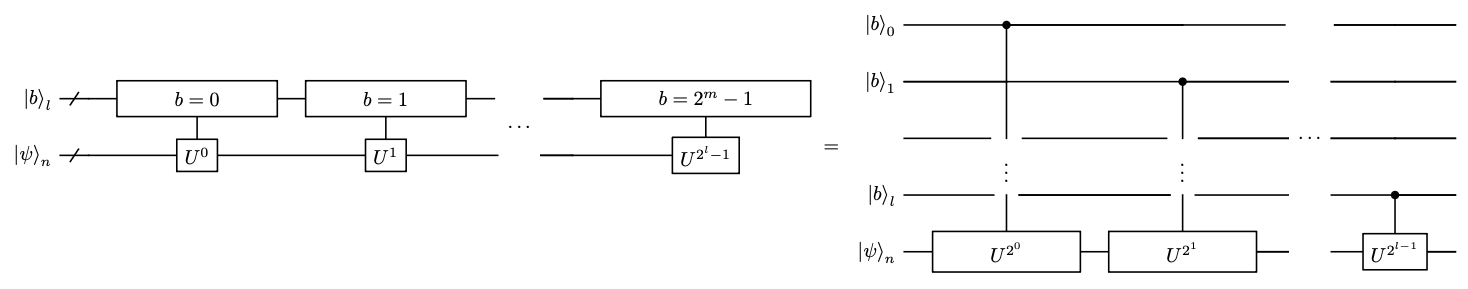
<center>
    Design of a select operation over a series of unitary powers. Instead of applying a series of $2^l$ multi-controlled operations, we can apply $l$ single controlled operations.
</center>

We build this specified select in the following function:

In [31]:
@qfunc
def select_powered_unitaries(u: QCallable, block: QArray):
    repeat(block.len, lambda i: control(block[i], lambda: power(2**i, lambda: u())))

Finally, we define a Quantum Struct for the Qubitization based block encoding, and build an `lcu_cheb` function that applies the LCU. We use  Classiq's `prepare_select` function, which allows a flexible implementation of the select operation in LCU. In our case we take this operation to be the `select_powered_unitaries` function.

In [32]:
class QubitizationBlock(QStruct):
    block_ham: QNum[block_size]
    block_exp: QArray[exp_block_size]


class QubitizationState(QStruct):
    data: QNum[data_size]
    block: QubitizationBlock


@qfunc
def lcu_cheb(
    coefs: list[float], be_qfunc: QCallable[BlockEncodedState], state: QubitizationState
):
    prepare_select(
        coefficients=coefs,
        select=lambda lcu_block: select_powered_unitaries(
            lambda: walk_operator(be_qfunc, [state.data, state.block.block_ham]),
            lcu_block,
        ),
        block=state.block.block_exp,
    )

The code in the rest of this section builds a model that applies the `lcu_cheb` function on the randomly prepared vector $(\vec{\psi},\vec{0})$, synthesizes it, executes the resulting quantum program, and verifies the results. 

In [33]:
@qfunc
def main(
    data: Output[QNum[data_size]], block: Output[QNum[block_size + exp_block_size]]
):
    state = QubitizationState()
    allocate(state)
    inplace_prepare_amplitudes(state_to_evolve, 0.0, state.data)

    lcu_cheb(
        exp_coeffs,
        be_hamiltonian,
        state,
    )
    bind(state, [data, block])


write_qmod(
    main,
    "hamiltonian_simulation_qubitization",
    decimal_precision=12,
    symbolic_only=False,
)

Synthesize the quantum model and execute it:

In [34]:
qprog_cheb_lcu = synthesize(main, preferences=Preferences(optimization_level=1))
show(qprog_cheb_lcu)

Quantum program link: https://platform.classiq.io/circuit/35YooDYsF7fQ2aYMO440LkYwwFn


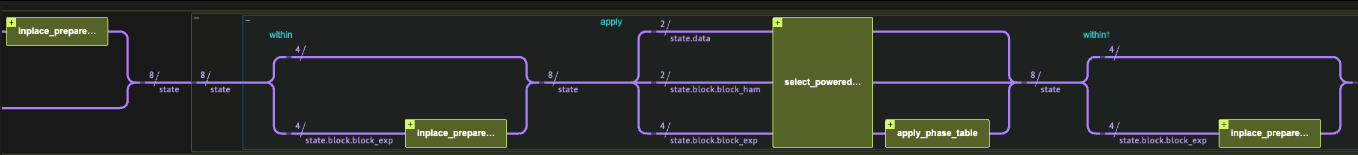

In [35]:
with ExecutionSession(qprog_cheb_lcu, execution_preferences) as es:
    results_cheb_lcu = es.sample()

state_result_cheb_lcu = get_projected_state_vector(results_cheb_lcu)
exp_scaling_factor_cheb_lcu = exp_be_scaling

For the verification, we call the pre-defined function for calculating the overlap:

In [36]:
renormalized_state_cheb_lcu, overlap_cheb_lcu = compare_quantum_classical_states(
    expected_state, state_result_cheb_lcu, exp_scaling_factor_cheb_lcu
)
print("expected state:", expected_state)
print("resulting state after rescaling:", renormalized_state_cheb_lcu)
assert np.linalg.norm(renormalized_state_cheb_lcu - expected_state) < EPS
print("=" * 40)
print("overlap between expected and resulting state:", overlap_cheb_lcu)

expected state: [-0.46396295-0.16168895j  0.47484851-0.25755303j  0.04128442-0.24362525j
 -0.27002281+0.57689723j]
resulting state after rescaling: [-0.46396295-0.16168895j  0.47484851-0.25755303j  0.04128442-0.24362525j
 -0.27002281+0.57689723j]
overlap between expected and resulting state: 1.0


***
***
## Summary


In [37]:
def get_qprog_data(qprog):
    return qprog.data.width, qprog.transpiled_circuit.count_ops["cx"]

In [38]:
widths = []
cx_counts = []

for qprog in [qprog_gqsp, qprog_qsvt, qprog_cheb_lcu]:
    widths.append(get_qprog_data(qprog)[0])
    cx_counts.append(get_qprog_data(qprog)[1])

exp_scaling = [
    exp_scaling_factor_gqsp,
    exp_scaling_factor_qsvt,
    exp_scaling_factor_cheb_lcu,
]

eff_cx_counts = [
    int(np.ceil(counts * scale)) for counts, scale in zip(cx_counts, exp_scaling)
]

exp_block_sizes = [block_size + 1, block_size + 2, block_size + exp_block_size]

methods = ["GQSP", "QSVT", "Cheb. LCU"]

preprocess_times = [
    classical_preprocess_time_gqsp,
    classical_preprocess_time_qsvt,
    classical_preprocess_time_chec_lcu,
]

state_distance = [
    np.linalg.norm(expected_state - state)
    for state in [
        renormalized_state_gqsp,
        renormalized_state_qsvt,
        renormalized_state_cheb_lcu,
    ]
]

In [39]:
import pandas as pd

df = pd.DataFrame(
    {
        "methods": methods,
        "block size": exp_block_sizes,
        "scaling factor ": exp_scaling,
        "width": widths,
        "cx counts": cx_counts,
        "effective cx counts": eff_cx_counts,
        "preprocess time [sec]": preprocess_times,
        "accuracy": state_distance,
    }
)
df

,methods,block size,scaling factor,width,cx counts,effective cx counts,preprocess time [sec],accuracy
0,GQSP,3,1.010101,7,8438,8524,0.060547,1.572627e-09
1,QSVT,4,2.020202,11,4886,9871,0.101416,1.312636e-11
2,Cheb. LCU,8,5.626479,12,7559,42531,0.000466,1.304466e-11


As we can see, the QSVT gives better results in terms of CX counts, however, its scaling factor means that in practice, its depth/CX-counts must be doubled in comparison to the GQSP result. For a scaling factor of 2 we need to apply 1 iteration of Oblivious Amplitude amplification, whereas for a factor of 4 we need to call it twice. In other words, measuring the block being at state 0 is 2 times less likely in the QSVT method, compared to the GQSP on. This issue is taken into account in the "effective CX counts" measure presented in the table. Even with this fact, the QSVT gives better results in terms of gate count, using one extra qubit. The Chebyshev LCU approach (Qubitization) is less effective in all parameters, except it requires no heavy preprocessing for calculating angles. We note that all three methods have the same asymptotic scaling, and the differences appeared in the tables are due to the detailed implementations of the current example.
***
***

<h3 id="references">References</h3>
<ol>
      <li id="ref-grand">
    Martyn, J. M., Rossi, Z. M., Tan, A. K., & Chuang, I. L. 
    <em>Grand unification of quantum algorithms.</em> 
    PRX Quantum <strong>2</strong>, 040203 (2021). 
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203" target="_blank" rel="noopener noreferrer">DOI &#8599;</a>
  </li>
  <li id="ref-gqsp">
    Motlagh, D, and Nathan W. Generalized quantum signal processing. PRX Quantum 5 020368 (2024). 
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.020368" target="_blank" rel="noopener noreferrer">DOI&#8599;</a>
  <li id="ref-bck">
  Berry, D. W., Childs, A. M., & Kothari, R.
  <em>Hamiltonian simulation with nearly optimal dependence on all parameters.</em>
  In <em>Proceedings of the 56th IEEE Symposium on Foundations of Computer Science (FOCS)</em>, pp. 792–809 (2015).
  <!-- External links -->
  &nbsp;- &nbsp;
  <a href="https://arxiv.org/abs/1501.01715" target="_blank" rel="noopener noreferrer">arXiv &#8599;</a>
  &nbsp;|&nbsp;
  <a href="https://doi.org/10.1109/FOCS.2015.54" target="_blank" rel="noopener noreferrer">DOI &#8599;</a>
</li>
  <li id="ref-jawiki">
    Jacobi–Anger Expansion. 
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://en.wikipedia.org/wiki/Jacobi%E2%80%93Anger_expansion" target="_blank" rel="noopener noreferrer">Wikipedia &#8599;</a>
  </li>
  <li id="ref-szegedy">
    Szegedy, M. 
    <em>Quantum speed-up of Markov chain based algorithms.</em> 
    In <em>45th Annual IEEE Symposium on Foundations of Computer Science</em>, pp. 32–41 (2004). 
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://ieeexplore.ieee.org/abstract/document/1366222" target="_blank" rel="noopener noreferrer">IEEE &#8599;</a>
  </li>
  <li id="ref-lin">
    Lin, L. <em>Lecture notes on quantum algorithms for scientific computation.</em> arXiv:2201.08309 [quant-ph] (2022). 
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://arxiv.org/abs/2201.08309" target="_blank" rel="noopener noreferrer">arXiv &#8599;</a>
  </li>

  <li id="ref-kikuchi">
    Kikuchi, Y., McKeever, C., Coopmans, L., <em>et al.</em> 
    <em>Realization of quantum signal processing on a noisy quantum computer.</em> 
    <em>npj Quantum Information</em> <strong>9</strong>, 93 (2023). 
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://www.nature.com/articles/s41534-023-00762-0" target="_blank" rel="noopener noreferrer">DOI &#8599;</a>
  </li>

  <li id="ref-childs">
    Childs, A. M., Kothari, R., & Somma, R. D. 
    <em>Quantum algorithm for systems of linear equations with exponentially improved dependence on precision.</em> 
    <em>SIAM Journal on Computing</em> <strong>46</strong>, 1920–1950 (2017). 
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://arxiv.org/abs/1511.02306" target="_blank" rel="noopener noreferrer">arXiv &#8599;</a>
  </li>
       
</ol>


***
***

## Technical Notes

### Recap on Block-Encoding matrices 

The basic use of the block-encoding unitary is the following. Let us say we have a $(s, m, 0)$-encoding of a matrix $A$
$$
U_{(s, m, 0)-A} = \begin{pmatrix}
	 A/s & *  \\
	 * & * 
\end{pmatrix},
$$
where the dimension of $A$ is $2^n\times 2^n$.
Applying this unitary on the state 
$$
|\psi\rangle_n|0\rangle_m =|\psi\rangle_n \otimes 
\begin{pmatrix}
	 1  \\
      0\\
	 \vdots \\
  0
\end{pmatrix} =  
\begin{pmatrix}
	 |\psi\rangle_n  \\
      0\\
	 \vdots \\
  0
\end{pmatrix},
$$
yields
$$
U_{(s, m, 0)-A} \left(|\psi\rangle_n|0\rangle_m \right)  = 
\begin{pmatrix}
	 \frac{1}{s}A|\psi\rangle_n  \\
      0\\
	 \vdots \\
  0
\end{pmatrix}
+
\begin{pmatrix}
	 0  \\
      *\\
	 \vdots \\
  *
\end{pmatrix} = \frac{1}{s}A|\psi\rangle_n|0\rangle_m +\sum_{l\neq 0} c_l |\phi\rangle_n|l\rangle_m .
$$
Thus, if we measure $|0\rangle_m$ on the second variable, we know the first variable is the state $\frac{1}{s}A|\psi\rangle_n$. In terms of measurement, we can post-select on $|0\rangle_m$ to measure the desired state. We can amplify the success of this operation, given by $|\frac{1}{s}A|\psi\rangle_n|$, with Quantum Amplitude Amplification.

### Recap on LCU

The task of LCU is to block-encode a sum of unitary functions:
$$
U_{(\bar{\alpha},m,0)-A} =\begin{pmatrix}
A/\bar{\alpha} & * \\
* & *
\end{pmatrix}, \text{   for     } A = \sum^{L-1}_{i=0} \alpha_i U_i, \,\,\,\,\, \alpha_i\geq 0.
$$
This operation is implemented by the so-called `prepare` and `select` operations. The `prepare` function is simply a state preparation function on the block variable:
$$
\mathrm{PREPARE} \equiv \mathcal{I} \otimes \left(\sum^{L-1}_{i=0}\sqrt{\alpha_i/\bar{\alpha}} |i\rangle \langle 0| +\sum^{L-1}_{i=0}\sum^{L-1}_{j=1}g_{ij}|i\rangle \langle j|\right),
$$
where $g_{ij}$ are some uninteresting coefficients, and $\mathcal{I}$ is the identity operation working on the data space. The `select` operation acts as a quantum switch, applying the operation $U_i$ on the data variable if the block variable is at state $|i\rangle$:
$$
\mathrm{SELECT} \equiv \sum_{i}U_i \otimes \left(|i\rangle \langle i|\right).
$$
The LCU operation is acheived by $\mathrm{PREPARE}\cdot \mathrm{SELECT}\cdot \mathrm{PREPARE}^{\dagger}$. One can check that:
\begin{align}
\left(\mathcal{I} \otimes \left(\sum^{L-1}_{i=0}\sqrt{\alpha_i/\bar{\alpha}} |i\rangle \langle 0| +\sum^{L-1}_{i=0}\sum^{L-1}_{j=1}g_{ij}|i\rangle \langle j|\right)\right)
\left( \sum_{i'}U_{i'} \otimes \left(|i'\rangle \langle i'|\right) \right)
\left(\mathcal{I} \otimes \left(\sum^{L-1}_{i''=0}\sqrt{\alpha_{i''}/\bar{\alpha}} |0\rangle \langle i''| +\sum^{L-1}_{i''=0}\sum^{L-1}_{j''=1}g^{*}_{i''j''}|j''\rangle \langle i''|\right)\right) =\\
= \left(\sum^{L-1}_{i=0}(\alpha_i/\bar{\alpha}) U_{i} \right) \otimes |0\rangle \langle 0| + \left(\sum^{L-1}_{i=1}\sum^{L-1}_{j=1}G_{ij}|i\rangle \langle j|\right),
\end{align}
with $G_{ij}$ some non-interesting operators.

### Generalizing to non-Hermitian $U_H$

The GQSP and Qubitization methods assumes that the block-encoding unitary is also Hermitian. This assumption sets the two propetries of the walk operator, Eqs. (6) and (7), on which those two methods are based upon.  In the case of non-Hermitian unitary block-encoding, the cited property of the walk operator $W$ does not hold. However, a similar property holds for $\tilde{W}\equiv U_{(s,m,0)-H}^T\Pi_{|0\rangle_m} U_{(s,m,0)-H}\Pi_{|0\rangle_m}$ (See Sec. 7.4 in Ref.  [<a href="#ref-lin">6</a>].) We can work with this operator, and with its equivalent properties that generalize Eqs. (6) and (7).